## Modeling - Citation Prediction

In [ ]:
# basic
import sys
import os
import json
import pdb
import ast
import time
import requests
import math
from tqdm import tqdm
from collections import Counter, defaultdict, namedtuple

# debug
import pdb
from loguru import logger

import numpy as np
import pandas as pd

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from tabulate import tabulate

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn import metrics

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklego.meta import ZeroInflatedRegressor
import xgboost
from xgboost.sklearn import XGBRegressor

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# from warnings import filterwarnings
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.bool` is a deprecated alias')
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.int` is a deprecated alias' )
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.object` is a deprecated alias')


# custom
from utils import *

SEED = 0

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shreyanasa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data

In [ ]:
def bin_citation_counts(x, n_clusters):
    rng = (x.max() - x.min()) / (n_clusters - 1)
    return np.ceil(x.map(lambda y : (y - x.min()) / rng))

def sample_data(works, YEAR, N_CLASSES, seed):
    works['reg'] = works['counts_by_year'].map(lambda x: np.sum([v for k, v in x if k in [YEAR, YEAR+1, YEAR+2]]))
    works['bin'] = bin_citation_counts(works['reg'], n_clusters=N_CLASSES)
    works = works.groupby('bin', group_keys=False).apply(lambda x: x.sample(frac = 1 if 7000/x.shape[0] > 1  else 7000/x.shape[0]))
    return works

In [ ]:
%%time
YEAR = 2017

works = pd.read_pickle(f'./data/{YEAR}/works.{YEAR}.v2.pkl').set_index('id')
print(bin_citation_counts(works['counts_by_year'].map(lambda x: np.sum([v for k, v in x if k in [YEAR, YEAR+1, YEAR+2]])), \
    n_clusters=200).value_counts())

1.0      81457
0.0      63048
2.0       1619
3.0        379
4.0        188
5.0         97
6.0         74
7.0         47
8.0         38
9.0         22
10.0        21
12.0        12
11.0         8
14.0         8
16.0         6
17.0         5
18.0         4
19.0         3
27.0         2
13.0         2
22.0         2
15.0         2
20.0         2
30.0         2
24.0         2
129.0        1
38.0         1
123.0        1
133.0        1
62.0         1
53.0         1
68.0         1
40.0         1
85.0         1
36.0         1
54.0         1
59.0         1
29.0         1
48.0         1
41.0         1
52.0         1
26.0         1
34.0         1
33.0         1
21.0         1
28.0         1
199.0        1
Name: counts_by_year, dtype: int64
CPU times: user 1min, sys: 3.78 s, total: 1min 4s
Wall time: 1min 29s


In [ ]:
works = sample_data(works, YEAR, 200, SEED)
print(works['bin'].value_counts())

0.0      7000
1.0      7000
2.0      1619
3.0       379
4.0       188
5.0        97
6.0        74
7.0        47
8.0        38
9.0        22
10.0       21
12.0       12
14.0        8
11.0        8
16.0        6
17.0        5
18.0        4
19.0        3
22.0        2
30.0        2
27.0        2
24.0        2
15.0        2
13.0        2
20.0        2
21.0        1
52.0        1
133.0       1
129.0       1
123.0       1
85.0        1
68.0        1
62.0        1
59.0        1
54.0        1
53.0        1
41.0        1
48.0        1
40.0        1
38.0        1
36.0        1
34.0        1
33.0        1
29.0        1
28.0        1
26.0        1
199.0       1
Name: bin, dtype: int64


In [ ]:
authors = pd.read_pickle(f'./data/{YEAR}/authors.{YEAR}.v2.pkl').set_index('id')
venues = pd.read_pickle(f'./data/{YEAR}/venues.{YEAR}.v2.pkl').set_index('id')
insts = pd.read_pickle(f'./data/{YEAR}/insts.{YEAR}.v2.pkl').set_index('id')

In [ ]:
bin_counts = works['bin'].value_counts()

In [ ]:
np.sum(bin_counts)

16567

In [ ]:
%%time
works, authors, venues, insts = preprocess_data(works, YEAR, 2022, authors, venues, insts)

CPU times: user 777 ms, sys: 50.8 ms, total: 828 ms
Wall time: 1 s


In [ ]:
print (f'works \n - shape={works.shape} \n - columns={works.columns.tolist()} \n\n')
print (f'authors \n - shape={authors.shape} \n - columns={authors.columns.tolist()} \n\n')
print (f'venues \n - shape={venues.shape} \n - columns={venues.columns.tolist()} \n\n')
print (f'insts \n - shape={insts.shape} \n - columns={insts.columns.tolist()} \n\n')

works 
 - shape=(14900, 16) 
 - columns=['doi', 'title', 'type', 'publication_date', 'host_venue', 'open_access_is_oa', 'open_access_oa_status', 'authorships', 'page_count', 'cited_by_count', 'concepts', 'referenced_works', 'abstract', 'counts_by_year', 'reg', 'bin'] 


authors 
 - shape=(344470, 7) 
 - columns=['orchid', 'display_name', 'works_count', 'cited_by_count', 'created_date', 'concepts', 'counts_by_year'] 


venues 
 - shape=(1854, 8) 
 - columns=['display_name', 'works_count', 'cited_by_count', 'is_oa', 'type', 'created_date', 'concepts', 'counts_by_year'] 


insts 
 - shape=(13227, 10) 
 - columns=['display_name', 'country_code', 'type', 'homepage_url', 'works_count', 'cited_by_count', 'associated_institutions', 'concepts', 'counts_by_year', 'created_date'] 




In [ ]:
# works
print (works.shape)
works.head()

(14900, 16)


,doi,title,type,publication_date,host_venue,open_access_is_oa,open_access_oa_status,authorships,page_count,cited_by_count,concepts,referenced_works,abstract,counts_by_year,reg,bin
id,,,,,,,,,,,,,,,,
W2603758391,https://doi.org/10.1063/1.4978823,Development of automated system for real-time ...,proceedings-article,2017-03-30,V4306419764,False,closed,"[[A2602989104, [I4576418]], [A2098012761, [I42...",-1,2,"[[C163985040, 0.79610956], [C50497907, 0.79075...","[W1968981286, W2058964435, W2060664919, W20726...",Recent developments in Laser Induced Breakdown...,"[(2017, 0), (2018, 0), (2019, 0), (2020, 2), (...",0.0,0.0
W2786978339,https://doi.org/10.1109/pimrc.2017.8292646,On the use of TEE for mission critical public ...,proceedings-article,2017-10-01,V4306420697,False,closed,"[[A2885294263, [I109703491]]]",-1,0,"[[C38652104, 0.71923786], [C172191483, 0.70296...","[W2161186258, W2186405047, W2921286899]",Standards developed for Mission Critical Servi...,"[(2017, 0), (2018, 0), (2019, 0), (2020, 0), (...",0.0,0.0
W2730365081,https://doi.org/10.1109/wow.2017.7959400,Loss/resistance evaluation of SiC-MOSFET and S...,proceedings-article,2017-05-01,V4306418800,False,closed,"[[A2564054409, [I72375662]], [A2302138349, [I7...",-1,1,"[[C11190779, 0.76292104], [C2778413303, 0.7397...","[W2085054225, W2104019384, W2155388919, W23174...",This paper deals with attractive voltage-sourc...,"[(2017, 0), (2018, 0), (2019, 0), (2020, 1), (...",0.0,0.0
W2735594647,https://doi.org/10.1109/apemc.2017.7975434,A threat of malicious hardware using on-chip v...,proceedings-article,2017-06-01,V4306420133,False,closed,"[[A2939102391, [I180203408]], [A2735630529, [I...",-1,0,"[[C41008148, 0.6530515], [C46934059, 0.6098234...","[W1500140210, W1976955200, W2013289383, W20990...",A lot of ICs are fabricated in external foundr...,"[(2017, 0), (2018, 0), (2019, 0), (2020, 0), (...",0.0,0.0
W2776684101,https://doi.org/10.1109/isanp.2017.8228794,A substrate integrated magneto-electric dipole...,proceedings-article,2017-10-01,V4306420091,False,closed,"[[A2779206475, [I180726961]], [A2715348543, [I...",-1,0,"[[C113145756, 0.6974322], [C113950482, 0.65326...","[W2313511715, W2326269382]",A substrate integrated magneto-electric (ME) d...,"[(2017, 0), (2018, 0), (2019, 0), (2020, 0), (...",0.0,0.0


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
concepts = pd.read_pickle(f'./data/{YEAR}/concepts.{YEAR}.v2.pkl').set_index('id')
concept_embeddings = model.encode(concepts['display_name'])
concept_embeddings = pd.DataFrame(concept_embeddings).set_index(concepts.index)
# works['concepts_string'] = works['concepts'].map(lambda conc : ' '.join([concepts['display_name'][i[0]] for i in conc]))

In [ ]:
x = works['concepts'][0]
np.sum([float(i[1])*np.array(concept_embeddings.loc[i[0], :]) for i in x], axis = 0)

0     -0.127659
1      0.029823
2     -0.100904
3     -0.138962
4     -0.104739
         ...   
379    0.181963
380   -0.041748
381    0.214519
382   -0.024784
383    0.023965
Length: 384, dtype: float32

In [ ]:
concept_features = works['concepts'].map(lambda x : np.array(np.sum([float(i[1])*np.array(concept_embeddings.loc[i[0], :]) for i in x], axis = 0)))

In [ ]:
concept_features

id
W2787485786    [-0.12765943, 0.029822841, -0.100904495, -0.13...
W2581354549    [-0.10855119, 0.21417244, -0.016105846, 0.1161...
W2895806065    [-0.117521875, 0.096532986, -0.0578917, -0.052...
W2790104836    [0.15162073, 0.08717966, -0.14519803, -0.10146...
W2900398261    [-0.07566495, 0.11588998, -0.0983553, -0.01656...
                                     ...                        
W2585635281    [-0.11786493, -0.11787458, 0.037560012, -0.052...
W2555618208    [-0.08352411, -0.03834085, -0.06418224, -0.074...
W2561715562    [-0.021522168, 0.023841236, -0.10063442, 0.007...
W2557641257    [-0.17598891, -0.08458174, -0.08394943, -0.051...
W2963709863    [-0.10393591, 0.047622986, 0.019485105, -0.097...
Name: concepts, Length: 14864, dtype: object

In [ ]:
concept_features = pd.DataFrame(np.concatenate(concept_features.values).reshape(concept_features.shape[0], concept_features[0].size), columns = range(concept_features[0].size), index = works.index)
print(concept_features)

                  0         1         2         3         4         5    \
id                                                                        
W2603758391 -0.158582  0.081072 -0.108525 -0.044050 -0.098411 -0.217540   
W2786978339 -0.135063  0.081583 -0.113747 -0.179065 -0.026692 -0.040221   
W2730365081 -0.254135  0.103001 -0.070433  0.164020 -0.024768 -0.171477   
W2735594647 -0.195801  0.065272 -0.129707 -0.098416 -0.095095 -0.131725   
W2776684101 -0.113620  0.028029 -0.100143 -0.082863 -0.032538 -0.067401   
...               ...       ...       ...       ...       ...       ...   
W2585635281 -0.117865 -0.117875  0.037560 -0.052301 -0.100245 -0.068094   
W2555618208 -0.083524 -0.038341 -0.064182 -0.074529  0.015086 -0.126227   
W2561715562 -0.021522  0.023841 -0.100634  0.007992 -0.059834 -0.052602   
W2557641257 -0.175989 -0.084582 -0.083949 -0.051058 -0.056227 -0.095324   
W2963709863 -0.103936  0.047623  0.019485 -0.097498 -0.086247  0.000309   

                  6     

In [ ]:
works.info()


<class 'pandas.core.frame.DataFrame'>
Index: 14900 entries, W2603758391 to W2963709863
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   doi                    14854 non-null  object 
 1   title                  14900 non-null  object 
 2   type                   14900 non-null  object 
 3   publication_date       14900 non-null  object 
 4   host_venue             14900 non-null  object 
 5   open_access_is_oa      14900 non-null  bool   
 6   open_access_oa_status  14900 non-null  object 
 7   authorships            14900 non-null  object 
 8   page_count             14900 non-null  object 
 9   cited_by_count         14900 non-null  int64  
 10  concepts               14900 non-null  object 
 11  referenced_works       14900 non-null  object 
 12  abstract               14900 non-null  object 
 13  counts_by_year         14900 non-null  object 
 14  reg                    14900 non-null  floa

In [ ]:
# works['page_count'].unique()
# # TODO: error (can be ignored since <1% have page counts)
# works[works['page_count']=='(10,)']

In [ ]:
# Train Test Split: based on `works`
TEST_SIZE = 0.2
train_index, test_index = train_test_split(range(len(works)),
                                           test_size=TEST_SIZE, random_state=SEED)

### Feature Extraction

In [ ]:
df = get_features(works, authors, venues, insts, YEAR, N_CLASSES=2, seed=SEED)
df.shape

(14900, 15)

In [ ]:
# df = get_features(works, authors, venues, insts, YEAR, N_CLASSES=2, seed=SEED)
# print (df.shape)

## approach 1: 
# weights_temp = compute_class_weight(df['y_reg'])
# weights = df['y_reg'].map(lambda x: weights_temp[x])

## approach 2: k-bins
est = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
bins = est.fit_transform(df['y_reg'].values.reshape(-1, 1))
bins = pd.Series(bins[:, 0], index=df.index)
bin_sample_counts = bins.value_counts().to_dict()
weights = bins.map(lambda x: 1/bin_sample_counts[x])

##### Abstract Features

In [ ]:
# train doc2vec
docs = works.iloc[train_index]['abstract'].tolist()
train_doc2vec(docs, dims=128, saved_model_name='d2v.abstract.model', seed=SEED)

Tagging: 11920it [00:26, 453.95it/s]
Training: 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Model Saved: d2v.abstract.model


In [ ]:
# infer doc2vec
abs_feats = infer_doc2vec(works, 'abstract', df.index, dims=128, saved_model='d2v.abstract.model')

/Users/shreyanasa/Documents/Jupyter/citation_prediction/utils.py:274: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'{col}_{i}' for i in range(dims)]] = np.zeros((len(df), dims))
/Users/shreyanasa/Documents/Jupyter/citation_prediction/utils.py:274: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'{col}_{i}' for i in range(dims)]] = np.zeros((len(df), dims))
/Users/shreyanasa/Documents/Jupyter/citation_prediction/utils.py:274: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

In [ ]:
textual_features = concept_features.merge(abs_feats, how='outer', left_index=True, right_index=True).loc[concept_features.index]
print(textual_features.shape)

(14900, 512)


In [ ]:
textual_features.fillna(0, inplace=True)

In [ ]:
pca = PCA(n_components=512, svd_solver='full')
pca.fit(np.array(textual_features))

PCA(n_components=512, svd_solver='full')

In [ ]:
print(pca.explained_variance_ratio_)

[1.09661648e-01 5.17476280e-02 4.66102503e-02 3.05441836e-02
 2.87380883e-02 2.55516284e-02 2.25502686e-02 1.84245200e-02
 1.76560938e-02 1.69426931e-02 1.57011267e-02 1.43863180e-02
 1.38496370e-02 1.26527468e-02 1.23752727e-02 1.18292973e-02
 1.10886186e-02 1.07856102e-02 1.01298381e-02 9.57310901e-03
 9.18855322e-03 8.75781750e-03 8.54390705e-03 8.24325871e-03
 7.83718858e-03 7.69669310e-03 7.43351064e-03 6.91010738e-03
 6.81673613e-03 6.67684015e-03 6.48576020e-03 6.20349732e-03
 6.12187494e-03 5.99539689e-03 5.91277592e-03 5.62242341e-03
 5.38524121e-03 5.31583756e-03 5.13363152e-03 5.02915355e-03
 4.98835308e-03 4.94353067e-03 4.86593595e-03 4.70045002e-03
 4.65230720e-03 4.57501194e-03 4.44569353e-03 4.39049552e-03
 4.35861768e-03 4.30417359e-03 4.21982880e-03 4.20140589e-03
 4.07845441e-03 3.96011663e-03 3.94149595e-03 3.89280502e-03
 3.84001074e-03 3.77846982e-03 3.72636024e-03 3.64283064e-03
 3.61962115e-03 3.53102783e-03 3.51270613e-03 3.47822122e-03
 3.39578792e-03 3.330689

Text(0.5, 0, 'Component number')

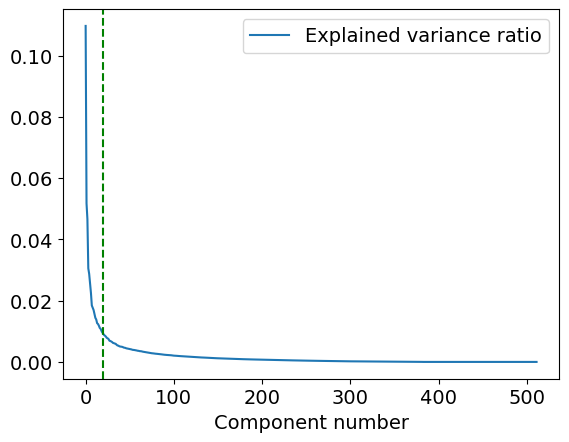

In [ ]:
plt.rcParams.update({'font.size': 14})
fig = sns.lineplot(pca.explained_variance_ratio_, label="Explained variance ratio")
fig.axvline(20, color = 'g', linestyle='--')
fig.set_xlabel('Component number')

In [ ]:
content_features = pca.fit_transform(textual_features)

/Users/shreyanasa/miniconda3/envs/anc2/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
c_f = pd.DataFrame(content_features).iloc[:, :16]

In [ ]:
content_columns = ['content_' + str(i) for i in range(16)]
c_f.columns = content_columns
c_f.index = textual_features.index

In [ ]:
c_f.head()

,content_0,content_1,content_2,content_3,content_4,content_5,content_6,content_7,content_8,content_9,content_10,content_11,content_12,content_13,content_14,content_15
id,,,,,,,,,,,,,,,,
W2603758391,0.072047,0.269731,0.441361,-0.270272,0.068695,0.159172,-0.492741,-0.096440,0.512473,-0.283181,0.204856,0.182541,0.395704,0.435514,0.219891,0.114889
W2786978339,-0.301153,0.532777,-0.365945,-0.193161,-0.069581,0.029098,-0.071863,-0.073377,0.489627,0.098019,-0.009807,0.200440,-0.189320,-0.277541,0.453458,-0.069673
W2730365081,0.873002,0.064215,-0.171154,0.133467,-0.178151,0.911247,-0.066327,-0.205357,-0.014901,0.038296,0.050930,-0.132796,0.046274,-0.143879,0.121057,0.161277
W2735594647,-0.175973,0.455027,-0.127733,-0.165148,-0.235238,0.100229,-0.117977,-0.279890,0.220488,0.035591,0.027395,0.167724,0.059990,-0.202686,0.090097,-0.008169
W2776684101,1.059258,0.318050,0.534539,-0.013585,-0.009786,-0.250594,0.400595,0.284946,-0.296369,0.378659,0.396949,0.193462,0.143808,0.085381,0.187106,0.146861


In [ ]:
# combine dataframes
combined_df = df.merge(c_f, how='outer', left_index=True, right_index=True).loc[df.index]
print (combined_df.shape)

(14900, 31)


In [ ]:
combined_df.loc[df.index].head()

,no_of_authors,no_of_referenced_works,open_access_is_oa,publication_month,author_prominency,authors_mean_citations,authors_mean_works,venue_citations,venue_works,venue_significance,...,content_6,content_7,content_8,content_9,content_10,content_11,content_12,content_13,content_14,content_15
id,,,,,,,,,,,,,,,,,,,,,
W2603758391,4,8,False,3,1,490.75,43.250000,1430,2969,0.481644,...,-0.492741,-0.096440,0.512473,-0.283181,0.204856,0.182541,0.395704,0.435514,0.219891,0.114889
W2786978339,1,3,False,10,0,0.00,0.000000,25417,2291,11.094282,...,-0.071863,-0.073377,0.489627,0.098019,-0.009807,0.200440,-0.189320,-0.277541,0.453458,-0.069673
W2730365081,8,5,False,5,1,75.75,23.750000,3,40,0.075000,...,-0.066327,-0.205357,-0.014901,0.038296,0.050930,-0.132796,0.046274,-0.143879,0.121057,0.161277
W2735594647,3,4,False,6,1,210.00,18.666667,9919,2263,4.383120,...,-0.117977,-0.279890,0.220488,0.035591,0.027395,0.167724,0.059990,-0.202686,0.090097,-0.008169
W2776684101,4,2,False,10,1,137.00,18.500000,5856,5521,1.060677,...,0.400595,0.284946,-0.296369,0.378659,0.396949,0.193462,0.143808,0.085381,0.187106,0.146861


In [ ]:
META_FEATURES = df.drop(columns=['y_reg', 'y_reg_norm', 'y_clf']).columns.tolist()
TEXT_FEATURES = content_columns

In [ ]:
combined_df.to_csv('./combined_df-32.csv')

In [ ]:
# combined_df['bin']

### Regression

In [ ]:
X = combined_df[META_FEATURES + TEXT_FEATURES]
# X = combined_df[META_FEATURES]
# X = combined_df[TEXT_FEATURES]
y = combined_df['y_reg_norm']

In [ ]:
# train - test split
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# scaler to convert normalized values to actual citations
elapsed_months = 2*12 + 12-df['publication_month']+1
c_train, c_test = elapsed_months.iloc[train_index], elapsed_months.iloc[test_index]

In [ ]:
# normalize
scaler = StandardScaler()
print (scaler.fit(X_train))

StandardScaler()


In [ ]:
w_train, w_test = weights.iloc[train_index], weights.iloc[test_index]

In [ ]:
# regression analysis
# ref: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

reg_models = {
    'Zero Regressor': DummyRegressor(strategy="constant", constant=0),
    'Mean Regressor': DummyRegressor(strategy="mean"),
    'Linear Regression': LinearRegression(n_jobs=-1),
    'Lasso Regression': Lasso(random_state=SEED),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=SEED, n_estimators=500),
    'SGD Regressor': SGDRegressor(random_state=SEED),
    'XGB Regressor': XGBRegressor(random_state=SEED, n_estimators=500),
    'Zero Inflated Regressor': ZeroInflatedRegressor(
        classifier=LogisticRegression(class_weight='balanced', random_state=SEED, n_jobs=-1), #MLPClassifier(random_state=SEED, max_iter=100), #SVC(random_state=SEED, max_iter=100, probability=True),
        regressor=LinearRegression()),
    # 'MLPRegressor': MLPRegressor(random_state=SEED, hidden_layer_sizes=1, learning_rate='adaptive', learning_rate_init=0.0001),
}

def eval_regression(model, X_train, X_test, y_train, y_test, c_train=None, c_test=None):
    c_train = 1 if c_train is None else c_train
    c_test = 1 if c_test is None else c_test
    
    y_train = y_train * c_train
    y_test = y_test * c_test
    # model eval
    y_pred = model.predict(X_train) * c_train
    rmse = metrics.mean_squared_error(y_true=y_train, y_pred=y_pred, squared=False, sample_weight=w_train)
    print (f"  - Train RMSE: {rmse}")
    mae = metrics.mean_absolute_error(y_true=y_train, y_pred=y_pred, sample_weight=w_train)
    print (f"  - Train MAE: {mae}")
    r2 = metrics.r2_score(y_true=y_train, y_pred=y_pred, sample_weight=w_train, force_finite=False)
    print (f"  - Train R^2: {r2}")
    train_metrics =[rmse, mae, r2]
    
    test_metrics = []
    y_pred = model.predict(X_test) * c_test
    rmse = metrics.mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False, sample_weight=w_test)
    print (f"  - Test RMSE: {rmse}")
    mae = metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred, sample_weight=w_test)
    print (f"  - Test MAE: {mae}")
    r2 = metrics.r2_score(y_true=y_test, y_pred=y_pred, sample_weight=w_test, force_finite=False)
    print (f"  - Test R^2: {r2}")
    test_metrics= [rmse, mae, r2]
    
    return train_metrics, test_metrics
    
table = []
for model_name, model in reg_models.items():
    # model train
    # Sample weights cannot be used with MLPRegressor
    model.fit(scaler.transform(X_train), y_train)#, sample_weight=w_train)

    print (f"{model_name}:")
    train_metrics, test_metrics = eval_regression(model, 
                                                  scaler.transform(X_train), 
                                                  scaler.transform(X_test),
                                                  y_train, y_test, 
                                                  c_train, c_test)
    
    table.append([model_name] + train_metrics + test_metrics)

# ref: https://github.com/astanin/python-tabulate
print ()
print ('Summary Report:')
headers = ['Model', 'Train RMSE', 'Train MAE', 'Train R^2', 'Test RMSE', 'Test MAE', 'Test R^2']
print(tabulate(table, headers, tablefmt="github", floatfmt=".3f")) 
# {'simple_outline', 'simple', 'latex'}

Zero Regressor:
  - Train RMSE: 211.307698441726
  - Train MAE: 171.4197875836614
  - Train R^2: -1.924823719890353
  - Test RMSE: 288.0463565954805
  - Test MAE: 223.51036457970218
  - Test R^2: -1.5132112054354367
Mean Regressor:
  - Train RMSE: 204.6185053800242
  - Train MAE: 163.49379756790503
  - Train R^2: -1.7425772731688816
  - Test RMSE: 281.7108525766535
  - Test MAE: 215.51043100337907
  - Test R^2: -1.403872176001494
Linear Regression:
  - Train RMSE: 170.8104512395029
  - Train MAE: 130.17402469371768
  - Train R^2: -0.9111639142612331
  - Test RMSE: 248.19219338989916
  - Test MAE: 181.12671596871928
  - Test R^2: -0.865865991164511
Lasso Regression:
  - Train RMSE: 204.6185053800242
  - Train MAE: 163.49379756790503
  - Train R^2: -1.7425772731688816
  - Test RMSE: 281.7108525766535
  - Test MAE: 215.51043100337907
  - Test R^2: -1.403872176001494
Gradient Boosting Regressor:
  - Train RMSE: 62.256310537852016
  - Train MAE: 49.938910095694816
  - Train R^2: 0.746115717

In [ ]:
print(tabulate(table, headers, tablefmt="latex", floatfmt=".3f")) 

\begin{tabular}{lrrrrrr}
\hline
 Model                       &   Train RMSE &   Train MAE &   Train R\^{}2 &   Test RMSE &   Test MAE &   Test R\^{}2 \\
\hline
 Zero Regressor              &      211.308 &     171.420 &      -1.925 &     288.046 &    223.510 &     -1.513 \\
 Mean Regressor              &      204.619 &     163.494 &      -1.743 &     281.711 &    215.510 &     -1.404 \\
 Linear Regression           &      170.810 &     130.174 &      -0.911 &     248.192 &    181.127 &     -0.866 \\
 Lasso Regression            &      204.619 &     163.494 &      -1.743 &     281.711 &    215.510 &     -1.404 \\
 Gradient Boosting Regressor &       62.256 &      49.939 &       0.746 &     237.600 &    167.603 &     -0.710 \\
 SGD Regressor               &      171.665 &     130.874 &      -0.930 &     249.818 &    182.054 &     -0.890 \\
 XGB Regressor               &        0.974 &       0.710 &       1.000 &     237.609 &    167.924 &     -0.710 \\
 Zero Inflated Regressor     &     

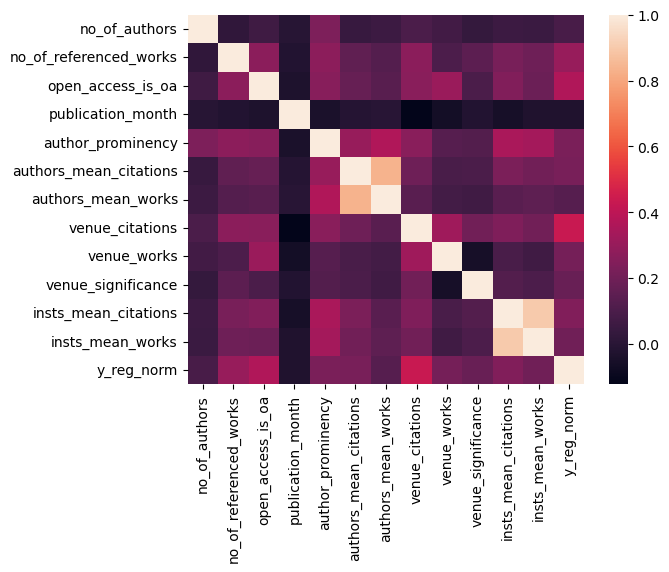

In [ ]:
# import numpy as np
# import pandas as pd

# from matplotlib import pyplot as plt
# %matplotlib inline
# import seaborn as sns

corr = combined_df[META_FEATURES + ['y_reg_norm']].corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

plt.savefig('corr.png', dpi=350, bbox_inches='tight')
# plt.xticks(rotation=70)
plt.show()

Feature: 0  Score: ('venue_citations', 0.8739516103146785)
Feature: 1  Score: ('authors_mean_citations', 0.24012393942326044)
Feature: 2  Score: ('content_15', -0.0)
Feature: 3  Score: ('content_14', 0.0)
Feature: 4  Score: ('no_of_referenced_works', 0.0)
Feature: 5  Score: ('open_access_is_oa', 0.0)
Feature: 6  Score: ('publication_month', 0.0)
Feature: 7  Score: ('author_prominency', 0.0)
Feature: 8  Score: ('authors_mean_works', 0.0)
Feature: 9  Score: ('venue_works', 0.0)
Feature: 10  Score: ('venue_significance', 0.0)
Feature: 11  Score: ('insts_mean_citations', 0.0)
Feature: 12  Score: ('insts_mean_works', 0.0)
Feature: 13  Score: ('content_0', -0.0)
Feature: 14  Score: ('content_1', -0.0)
Feature: 15  Score: ('content_2', -0.0)
Feature: 16  Score: ('content_3', 0.0)
Feature: 17  Score: ('content_4', -0.0)
Feature: 18  Score: ('content_5', 0.0)
Feature: 19  Score: ('content_6', -0.0)
Feature: 20  Score: ('content_7', -0.0)
Feature: 21  Score: ('content_8', 0.0)
Feature: 22  Score

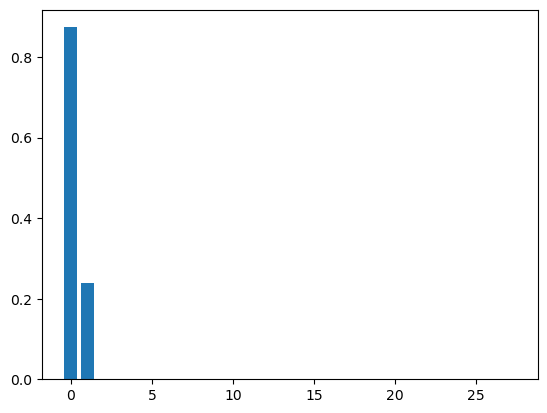

In [ ]:
# get importance for linear regression
model = reg_models['Lasso Regression']
model.fit(scaler.transform(X_train), y_train, sample_weight=w_train)

importance = model.coef_
indices = np.argsort(importance)[::-1]
for i,v in enumerate(zip(X.columns[indices], importance[indices])):
    print('Feature: {}  Score: {}' .format(i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance[indices])
plt.show()

### Classification

In [ ]:
# X = combined_df[META_FEATURES + TEXT_FEATURES]
X = combined_df[META_FEATURES]
# X = combined_df[TEXT_FEATURES]
y = combined_df['y_clf']

In [ ]:
y.value_counts(normalize=True)

0    0.772067
1    0.227933
Name: y_clf, dtype: float64

In [ ]:
# train - test split
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
# normalize
scaler = StandardScaler()
print (scaler.fit(X_train))

StandardScaler()


In [ ]:
# classification analysis

clf_models = {
    # 'Majority Classifier': DummyClassifier(strategy='prior'),
    # 'Stratified Classifier': DummyClassifier(strategy='stratified'),
    # 'Random Classifier': DummyClassifier(strategy='uniform'),
    # 'LogisticRegression': LogisticRegression(random_state=SEED, n_jobs=-1),
    # 'XGBoost': xgboost.XGBClassifier(random_state=SEED),
    # 'GaussianNB': GaussianNB(),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=SEED),
    # 'SVC': SVC(random_state=SEED, max_iter=100, probability=True),
    'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
    'MLPClassifier': MLPClassifier(random_state=SEED, max_iter=100),
}

def eval_classification(model, X_train, X_test, y_train, y_test):
    # model eval
    y_pred = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    acc = metrics.accuracy_score(y_true=y_train, y_pred=y_pred, sample_weight=w_train)
    print (f'  - Train Accuracy (in %): {acc}')
    f1 = metrics.f1_score(y_true=y_train, y_pred=y_pred, average='weighted')
    print (f'  - Train F1: {f1}')
    auc = metrics.roc_auc_score(y_true=y_train, y_score=y_pred_proba, average='weighted')
    print (f'  - Train AUC: {auc}')
    train_metrics = [acc, f1, auc]
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred, sample_weight=w_test)
    print (f'  - Test Accuracy (in %): {acc}')
    f1 = metrics.f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print (f'  - Test F1: {f1}')
    auc = metrics.roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='weighted')
    print (f'  - Test AUC: {auc}')
    test_metrics = [acc, f1, auc]
    
    print ('Classification Report:')
    print (metrics.classification_report(y_true=y_test, y_pred=y_pred))
    
    print ('Confusion Matrix (0,1) (rows: actual, cols:predicted):')
    print (metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))
    return train_metrics, test_metrics
    
table = []
for model_name, model in clf_models.items():
    # model train
    model.fit(scaler.transform(X_train), y_train)#, sample_weight=w_train)

    print (f"{model_name}:")
    train_metrics, test_metrics = eval_classification(model, 
                                                      scaler.transform(X_train), 
                                                      scaler.transform(X_test),
                                                      y_train, y_test)
    
    table.append([model_name] + train_metrics + test_metrics)
    
print ()
print ('Summary Report:')
headers = ['Model', 'Train Accuracy', 'Train F1', 'Train AUC', 'Test Accuracy', 'Test F1', 'Test AUC']
print(tabulate(table, headers, tablefmt="github", floatfmt=".3f")) 
# {'simple_outline', 'simple', 'latex'}

KNeighborsClassifier:
  - Train Accuracy (in %): 0.8651362431874708
  - Train F1: 0.8733957840482187
  - Train AUC: 0.9329220346794542
  - Test Accuracy (in %): 0.8901821744300745
  - Test F1: 0.8335107985299616
  - Test AUC: 0.8126498743697794
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2286
           1       0.72      0.52      0.61       687

    accuracy                           0.84      2973
   macro avg       0.79      0.73      0.75      2973
weighted avg       0.83      0.84      0.83      2973

Confusion Matrix (0,1) (rows: actual, cols:predicted):
[[2147  139]
 [ 328  359]]
MLPClassifier:
  - Train Accuracy (in %): 0.8973672588803767
  - Train F1: 0.8634537238475974
  - Train AUC: 0.8841655389794374
  - Test Accuracy (in %): 0.9293132702313089
  - Test F1: 0.8590759341109939
  - Test AUC: 0.8837376041240841
Classification Report:
              precision    recall  f1-score   support

       

/Users/shreyanasa/miniconda3/envs/anc2/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
print(tabulate(table, headers, tablefmt="latex", floatfmt=".3f")) 

\begin{tabular}{lrrrrrr}
\hline
 Model                  &   Train Accuracy &   Train F1 &   Train AUC &   Test Accuracy &   Test F1 &   Test AUC \\
\hline
 Majority Classifier    &            0.980 &      0.084 &       0.500 &           0.978 &     0.087 &      0.500 \\
 Stratified Classifier  &            0.948 &      0.111 &       0.500 &           0.969 &     0.127 &      0.500 \\
 Random Classifier      &            0.420 &      0.547 &       0.500 &           0.665 &     0.547 &      0.500 \\
 LogisticRegression     &            0.980 &      0.084 &       0.839 &           0.978 &     0.087 &      0.854 \\
 XGBoost                &            0.980 &      0.084 &       0.688 &           0.978 &     0.087 &      0.681 \\
 GaussianNB             &            0.911 &      0.808 &       0.811 &           0.944 &     0.815 &      0.827 \\
 DecisionTreeClassifier &            1.000 &      1.000 &       1.000 &           0.874 &     0.794 &      0.711 \\
 SVC                    &        

Feature: 0  Score: ('venue_citations', 0.3669484801508448)
Feature: 1  Score: ('open_access_is_oa', 0.3450025456425234)
Feature: 2  Score: ('author_prominency', 0.2527776746853726)
Feature: 3  Score: ('no_of_referenced_works', 0.2459918805890039)
Feature: 4  Score: ('venue_significance', 0.23394786530802528)
Feature: 5  Score: ('insts_mean_citations', 0.1704465942538976)
Feature: 6  Score: ('authors_mean_citations', 0.15691865135347102)
Feature: 7  Score: ('venue_works', 0.1354785616888419)
Feature: 8  Score: ('insts_mean_works', 0.12250659575812667)
Feature: 9  Score: ('no_of_authors', 0.1218885467319542)
Feature: 10  Score: ('content_5', 0.1009005536861742)
Feature: 11  Score: ('content_6', 0.08097079126269018)
Feature: 12  Score: ('content_9', 0.06722797454146925)
Feature: 13  Score: ('content_1', 0.052460971099461066)
Feature: 14  Score: ('authors_mean_works', 0.0471102845758563)
Feature: 15  Score: ('content_14', 0.03412861202316038)
Feature: 16  Score: ('content_4', 0.02124075416

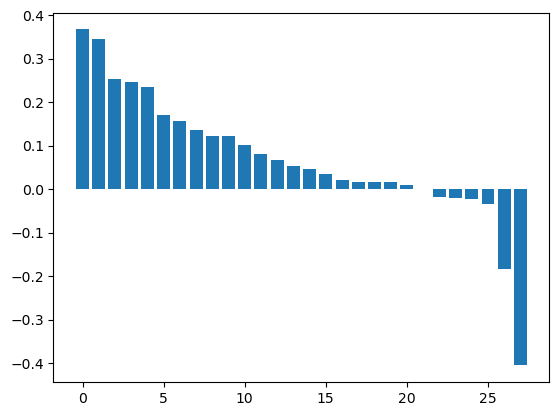

In [ ]:
# get importance for logistic regression
model = clf_models['LogisticRegression']
model.fit(scaler.transform(X_train), y_train, sample_weight=w_train)

importance = model.coef_[0]
indices = np.argsort(importance)[::-1]
for i,v in enumerate(zip(X.columns[indices], importance[indices])):
    print('Feature: {}  Score: {}' .format(i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance[indices])
plt.show()

## rough

In [ ]:
df['y_reg'].describe(percentiles=[i/100 for i in range(0,100,10)])

count    145531.000000
mean          2.516570
std           8.101248
min           0.000000
0%            0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.000000
50%           1.000000
60%           1.000000
70%           2.000000
80%           3.000000
90%           6.000000
max         662.000000
Name: y_reg, dtype: float64

<AxesSubplot:xlabel='y_reg', ylabel='Count'>

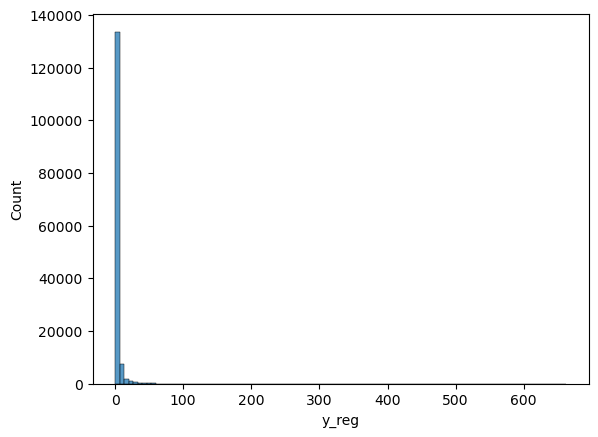

In [ ]:
temp = df[df['y_reg']<50000].reset_index()
sns.histplot(data=temp, x="y_reg", bins=100)

In [ ]:
works[works['cited_by_count']>200]

,doi,title,type,publication_date,host_venue,open_access_is_oa,open_access_oa_status,authorships,page_count,cited_by_count,concepts,referenced_works,abstract,counts_by_year
id,,,,,,,,,,,,,,
W2555618208,https://doi.org/10.1109/cvpr.2017.691,Multi-view 3D Object Detection Network for Aut...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2119051707, [I99065089]], [A2151001937, [I9...",-1,1409,"[[C131979681, 0.86888766], [C41008148, 0.77201...","[W7746136, W1536680647, W1914646313, W19466097...",This paper aims at high-accuracy 3D object det...,"[(2017, 13), (2018, 109), (2019, 308), (2020, ..."
W2557641257,https://doi.org/10.1109/cvpr.2017.733,ECO: Efficient Convolution Operators for Tracking,proceedings-article,2017-07-21,V4306417987,True,green,"[[A260882311, [I102134673]], [A2557978175, [I1...",-1,1322,"[[C63479239, 0.8030945], [C68339613, 0.7788200...","[W1857884451, W1892578678, W1904671147, W19157...","In recent years, Discriminative Correlation Fi...","[(2017, 9), (2018, 133), (2019, 303), (2020, 3..."
W2963709863,https://doi.org/10.1109/cvpr.2017.241,Learning from Simulated and Unsupervised Image...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2183241032, [I1311269955]], [A2798413642, [...",-1,1277,"[[C41008148, 0.8212265], [C2779803651, 0.78661...","[W1922126009, W1950149599, W1995694455, W20012...","With recent progress in graphics, it has becom...","[(2017, 55), (2018, 251), (2019, 356), (2020, ..."
W2594519801,https://doi.org/10.1109/cvpr.2017.261,ScanNet: Richly-Annotated 3D Reconstructions o...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2158018495, [I97018004]], [A2111957820, [I2...",-1,1116,"[[C41008148, 0.8516614], [C82990744, 0.6491697...","[W218762409, W1509835260, W1565402342, W159436...",A key requirement for leveraging supervised de...,"[(2017, 12), (2018, 76), (2019, 226), (2020, 3..."
W2561715562,https://doi.org/10.1109/cvpr.2017.215,CLEVR: A Diagnostic Dataset for Compositional ...,proceedings-article,2017-07-01,V4306417987,True,green,"[[A2345205178, [I97018004]], [A1988254826, [I2...",-1,1085,"[[C41008148, 0.7745689], [C130440534, 0.751482...","[W1933349210, W1983927101, W1996418862, W20646...",When building artificial intelligence systems ...,"[(2017, 38), (2018, 146), (2019, 232), (2020, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W2964297864,https://doi.org/10.1109/iccv.2017.137,Adversarial PoseNet: A Structure-Aware Convolu...,proceedings-article,2017-04-30,V4306419272,True,green,"[[A2672142776, [I36399199]], [A2139473605, [I5...",-1,205,"[[C2779803651, 0.8591261], [C177769412, 0.8495...","[W1936750108, W1994529670, W2013640163, W20318...","For human pose estimation in monocular images,...","[(2017, 2), (2018, 36), (2019, 65), (2020, 48)..."
W2555428947,https://doi.org/10.18653/v1/d17-1039,Unsupervised Pretraining for Sequence to Seque...,proceedings-article,2017-09-01,V4306418267,True,hybrid,"[[A2953580041, [I157725225]], [A2551433269, [I...",-1,204,"[[C170858558, 0.8504702], [C203005215, 0.82808...","[W23305027, W1544827683, W1591801644, W1753482...",This work presents a general unsupervised lear...,"[(2017, 11), (2018, 40), (2019, 78), (2020, 40..."
W2963414781,https://doi.org/10.1109/asru.2017.8268935,"Exploring architectures, data and units for st...",proceedings-article,2017-12-01,V4306498158,True,green,"[[A2120260697, [I1291425158]], [A2639960128, [...",-1,204,"[[C41008148, 0.85740614], [C147168706, 0.82748...","[W1531333757, W1593247906, W2064675550, W21271...",We investigate training end-to-end speech reco...,"[(2017, 4), (2018, 27), (2019, 46), (2020, 62)..."


<AxesSubplot:xlabel='cited_by_count', ylabel='Count'>

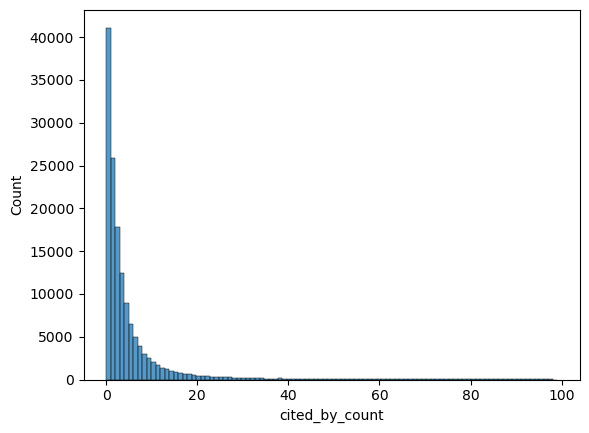

In [ ]:
temp = works[works['cited_by_count']<100].reset_index()
sns.histplot(data=temp, x="cited_by_count", bins=100)

<AxesSubplot:xlabel='cited_by_count', ylabel='Count'>

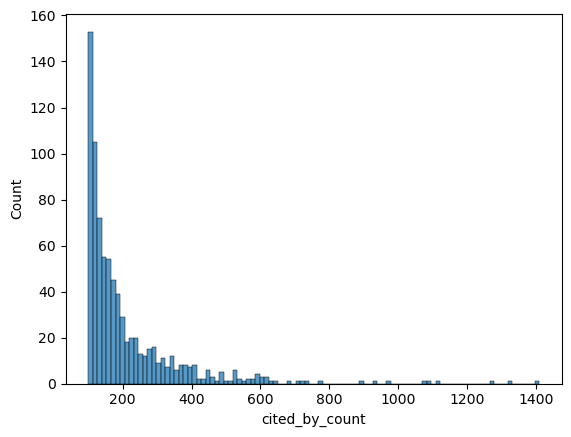

In [ ]:
temp = works[works['cited_by_count']>100].reset_index()
sns.histplot(data=temp, x="cited_by_count", bins=100)